In [1]:
from IPython.display import display
from IPython.display import Image

# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. CT data
### Authors: F. P. Vidal

# TODO

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to images generated with the state-of-the-art Monte Caro simulation packages. We take into account i) a realistic beam spectrum and ii) the energy response of the detector.

**Material and Methods:** We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).

In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic. The voltage is 85 kV. The filteration is 0.1 mm of copper and 1 mm of aluminium. The energy response of the detector is considered. It mimics a 600-micron thick CsI scintillator.

In [2]:
# Image(filename="../doc/pediatric-setup.png")

The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density. We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

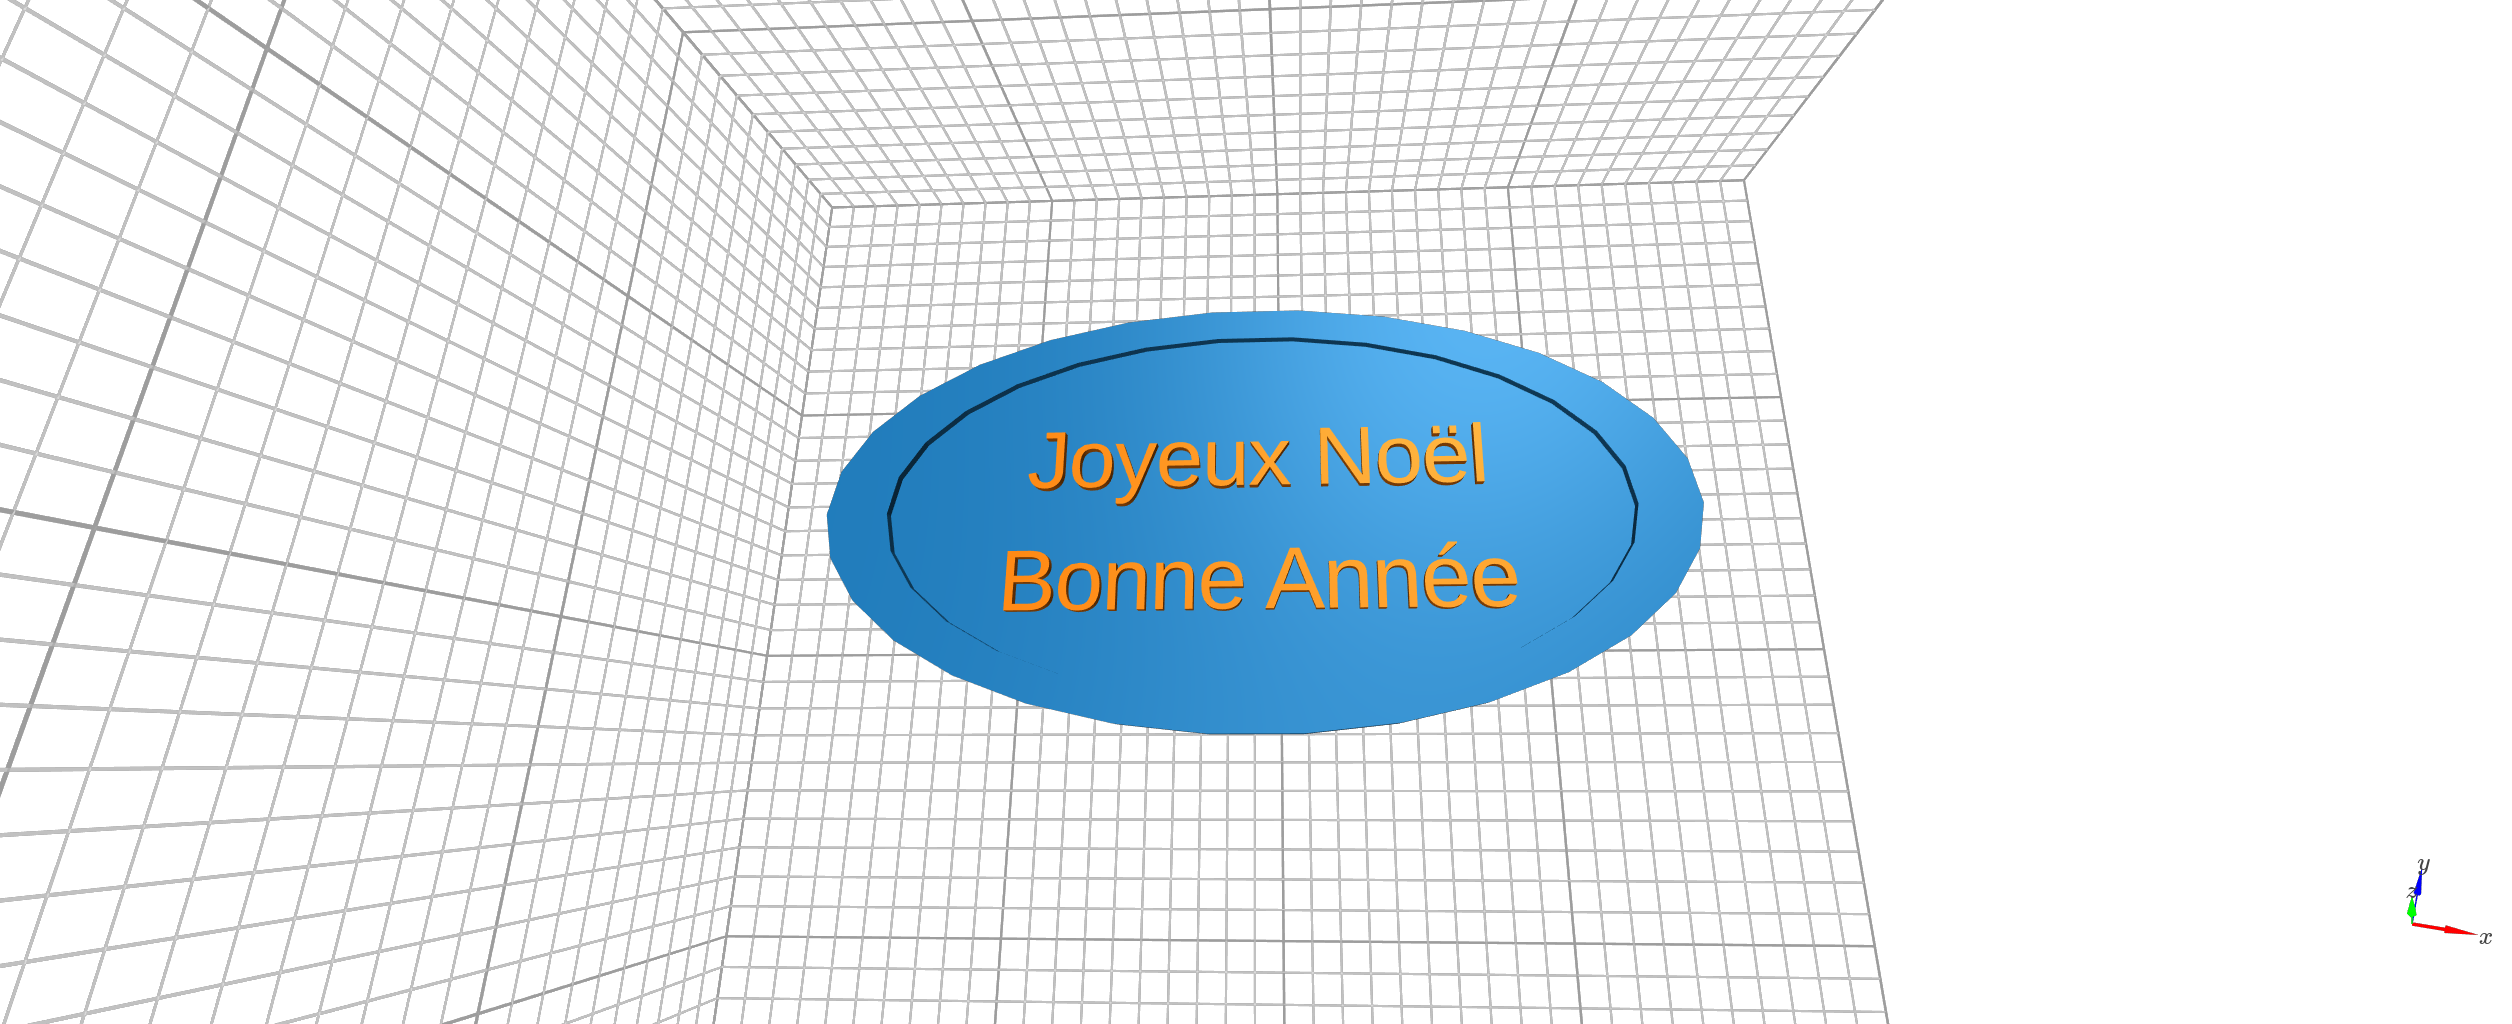

In [3]:
Image(filename="visualisation.png", width=800)

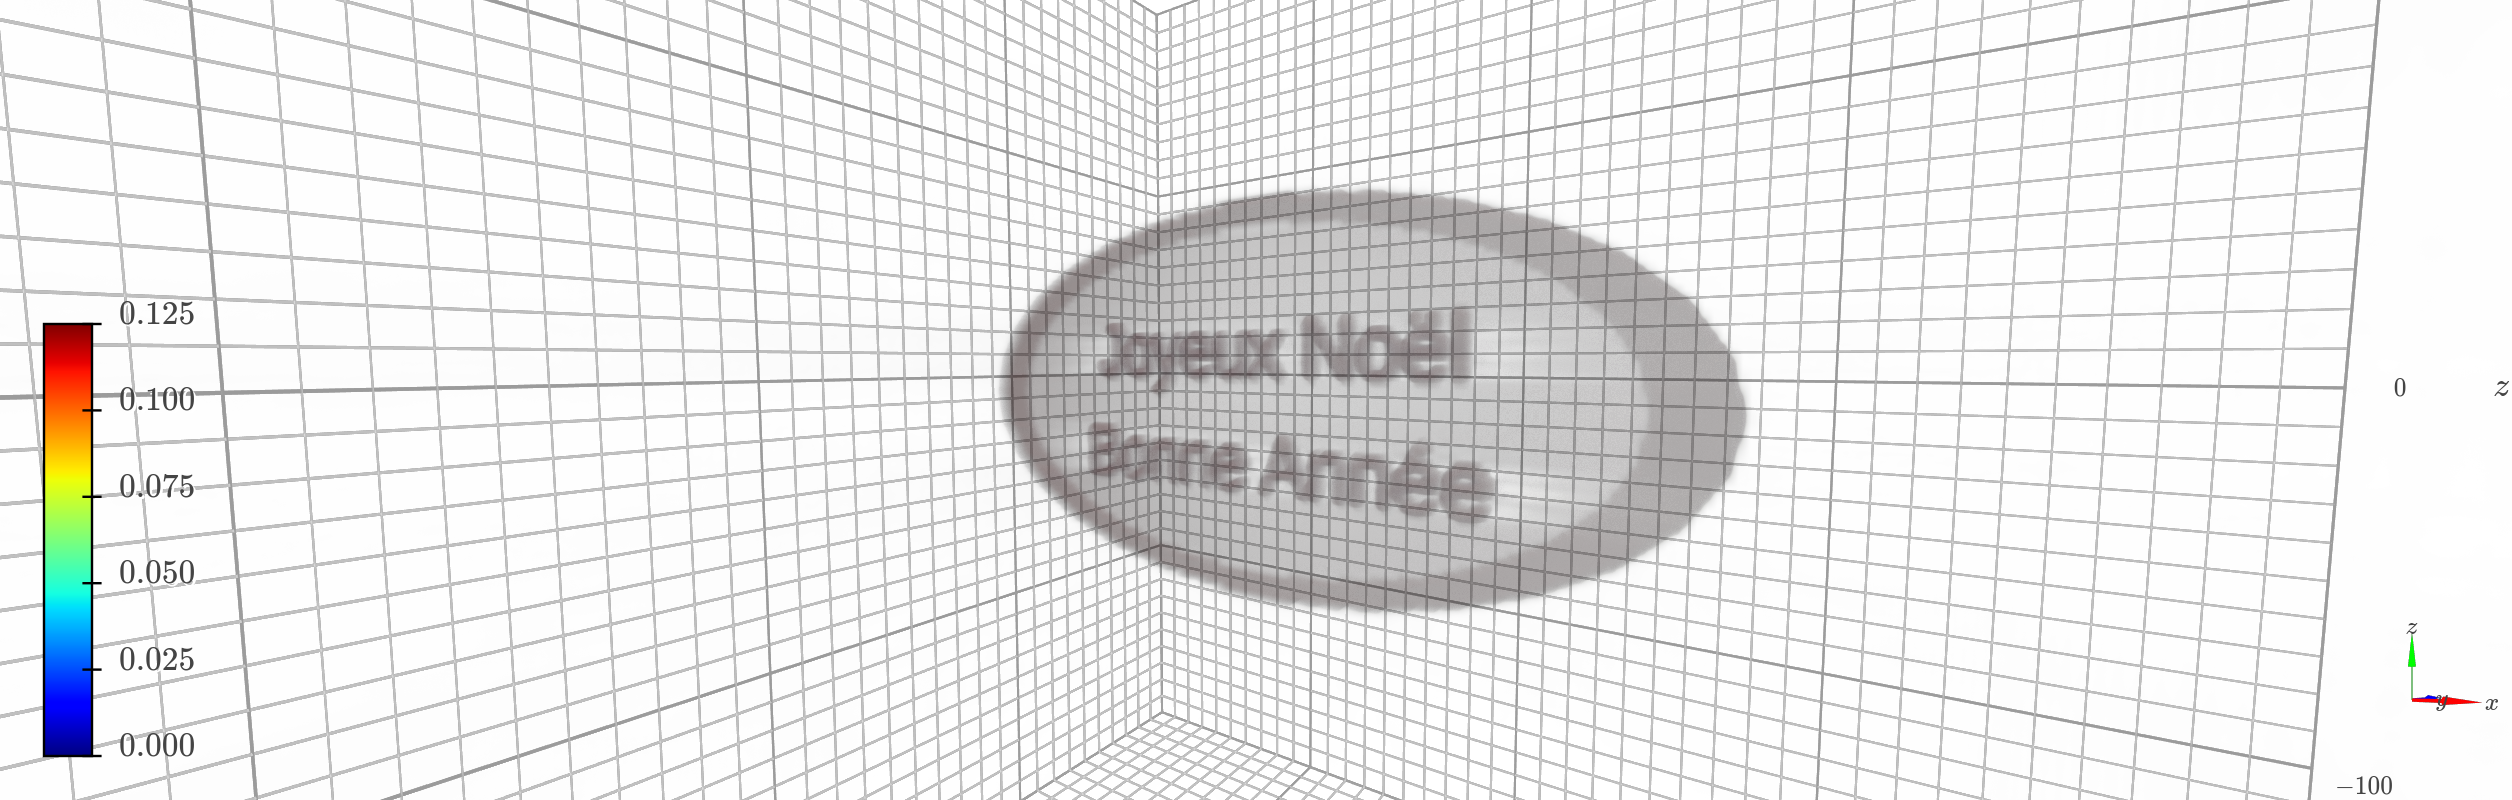

In [4]:
Image(filename="volume_rendering.png", width=800)

**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is **MAPE 3.43%**. The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is 99.99%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.99**. 
As MAPE is relatively low (less than 5%), SSIM is high (close to 1), and ZNCC is high (close to 100%), we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations that ran on supercomputers for days.

## Import packages

In [5]:
%matplotlib inline

import os # Locate files
# import urllib # Download file
# import zipfile # Unzip the file

import math
import numpy as np # Who does not use Numpy?
# import pandas as pd # Load/Write CSV files

import matplotlib
import matplotlib.pyplot as plt # Plotting

import viewscad # Use OpenSCAD to create STL files

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up


# from matplotlib.cm import get_cmap
# from matplotlib.colors import LogNorm # Look up table
# from matplotlib.colors import PowerNorm # Look up table
# import matplotlib.colors as mcolors

# font = {'family' : 'serif',
#         #'weight' : 'bold',
#          'size'   : 22
#        }
# matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)

import tomopy
# from skimage.transform import iradon

# from scipy.stats import pearsonr # Compute the correlatio coefficient

# from skimage.util import compare_images # Checkboard comparison between two images
# from skimage.metrics import structural_similarity as ssim
# from sklearn.metrics import mean_absolute_percentage_error as mape
# from skimage.metrics import structural_similarity as ssim
# from skimage.transform import resize # Resample the images

# from tifffile import imread, imsave # Load/Write TIFF files
import imageio

from scipy.ndimage import zoom

# import datetime # For the runtime

import k3d, base64 # For visualisation
import SimpleITK as sitk
from stl import mesh
# import random
# from sitk2vtk import sitk2vtk

# import gvxrPython3 as gvxr # Simulate X-ray images

# import json2gvxr # Set gVirtualXRay and the simulation up
# from utils import * # Code shared across more than one notebook

SimpleGVXR 1.0.1 (2021-12-13T16:30:11) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-13T16:30:10) [Compiler: GNU g++] on Linux


## Define constants for this experiment

In [6]:
number_of_projections = 784;
angular_step = 360 / number_of_projections;
theta_deg = np.linspace(0.0, -angular_step * number_of_projections, num=number_of_projections, endpoint=False)

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [7]:
json2gvxr.initGVXR("notebook.json", "OPENGL")

Create an OpenGL context: 500x500
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 500 500


## Create the 3D models

We now create CAD models using [OpenSCAD](https://openscad.org/) and extract the corresponding STL files. We adapt the ["sign"](https://github.com/openscad/openscad/tree/master/examples/Parametric) example from OpenSCAD.

In [8]:
openscad_make_text_str = """

//The resolution of the curves. Higher values give smoother curves but may increase the model render time.
resolution = 100; //[10, 20, 30, 50, 100]

//Total height of the sign
height = 2;//[1 : 10]

//Message to be write 
Message = "Merry Xmas"; //["Welcome to...", "Happy Birthday!", "Happy Anniversary", "Congratulations", "Thank You"]

//Name of Person, company etc.
To = "Happy new year";

$fn = resolution;

linear_extrude(height = height) {
    translate([0, --4]) text(Message, halign = "center");
    translate([0, -16]) text(To, halign = "center");
}

"""

In [9]:
fname = 'bonne_annee.stl'
if not os.path.isfile(fname):

    r = viewscad.Renderer()
    r.render(openscad_make_text_str, outfile=fname)

In [10]:
openscad_make_frame_str = """

//The resolution of the curves. Higher values give smoother curves but may increase the model render time.
resolution = 100; //[10, 20, 30, 50, 100]

//The horizontal radius of the outer ellipse of the sign.
radius = 70;//[60 : 200]

//Total height of the sign
height = 2;//[1 : 10]

$fn = resolution;

scale([1, 0.5]) difference() {
    cylinder(r = radius, h = 2 * height, center = true);
    translate([0, 0, height])
        cylinder(r = radius - 10, h = height + 1, center = true);}
"""

In [11]:
fname = 'frame.stl'
if not os.path.isfile(fname):

    r = viewscad.Renderer()
    r.render(openscad_make_frame_str, outfile=fname)

CGAL Cache insert: difference(){cylinder($fn=0,$fa=12,$fs=2 (162128 bytes)
CGAL Cache insert: multmatrix([[1,0,0,0],[0,0.5,0,0],[0,0,1 (162128 bytes)


Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [12]:
json2gvxr.initSamples(verbose=0)

file_name:	frame.stl	nb_faces:	236	nb_vertices:	708	bounding_box (in cm):	(-7, -3.48083, -0.2)	(7, 3.48083, 0.2)
file_name:	bonne_annee.stl	nb_faces:	9332	nb_vertices:	27996	bounding_box (in cm):	(-4.78654, -1.888, 0)	(4.88818, 1.3536, 0.2)


In [13]:
plot = k3d.plot()
plot.background_color = 0xffffff

for sample in json2gvxr.params["Samples"]:
    
    label = sample["Label"]
    fname = sample["Path"]
    
    r, g, b, a = gvxr.getAmbientColour(label)
    R = math.floor(255*r)
    G = math.floor(255*g)
    B = math.floor(255*b)
    A = math.floor(255*a)

    k3d_color = 0;
    k3d_color |= (R & 255) << 16;
    k3d_color |= (G & 255) << 8;
    k3d_color |= (B & 255);

    mesh_from_stl_file = mesh.Mesh.from_file(fname)

    geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                          range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                          color=k3d_color, 
                          wireframe=False, 
                          flat_shading=False,
                          name=fname,
                          opacity = 1)
    
    plot += geometry   
    
plot.display()
plot.camera = [6.558342532497144, -38.2302451616934, 138.03697775006287, 0, 0, 0, 0.01601809886866635, 0.9475520916520691, 0.3191997088257412]

Output()

In [14]:
fname = 'visualisation.png'
if not os.path.isfile(fname):

    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    plot.fetch_screenshot()

    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

## X-ray source

We create an X-ray source. It is a point source.

In [15]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, 0.0, 1000.0, 'mm']
	Source shape: ParallelBeam


## Spectrum

The spectrum is polychromatic. Each projection is acquired using 0.5 mm aluminium filtration and at 50 kvp. 

In [16]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

params["Source"]["Beam"] {'kvp': 50, 'tube angle': 12, 'filter': [['Al', 0.5]]}
['Al', 0.5]


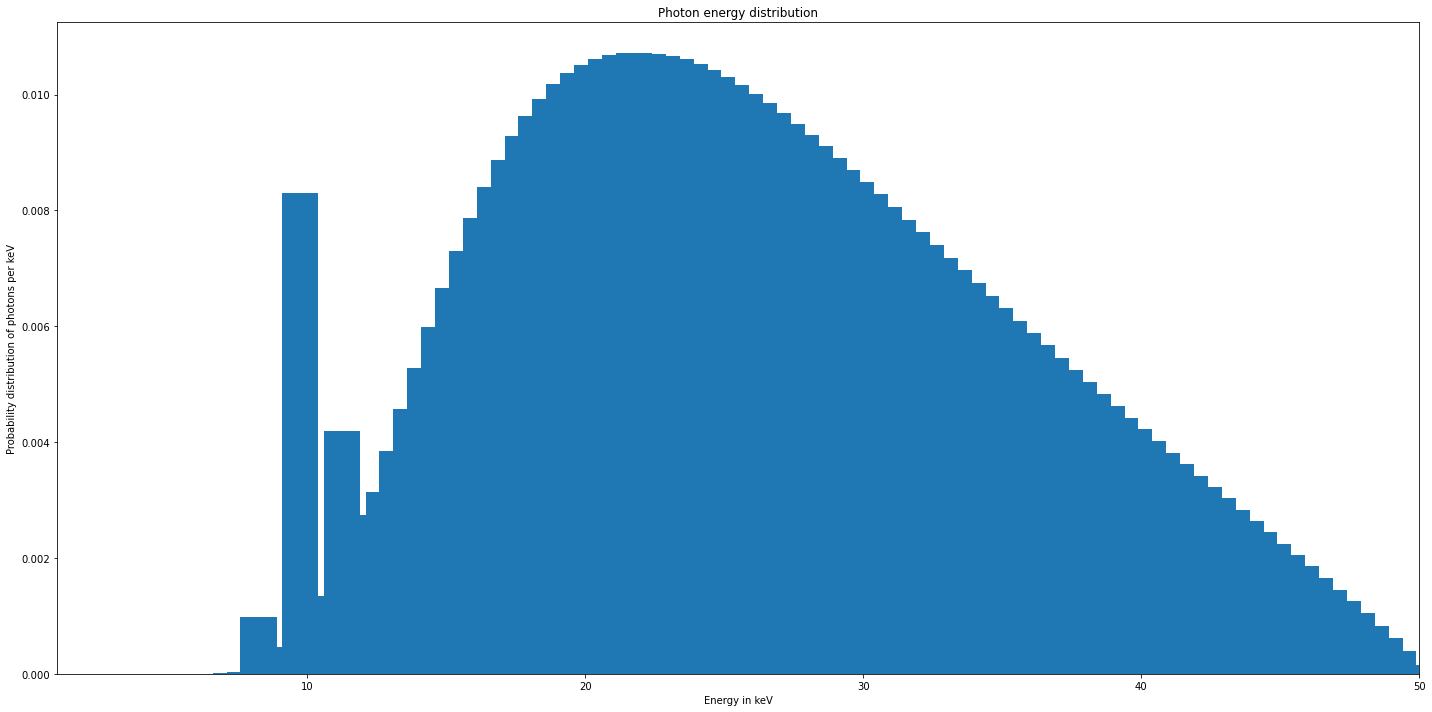

In [17]:
xlim=[np.min(k), np.max(k)]

plt.figure(figsize= (20,10))

plt.bar(k, f / f.sum()) # Plot the spectrum
plt.xlabel('Energy in keV')
plt.ylabel('Probability distribution of photons per keV')
plt.title('Photon energy distribution')

plt.xlim(xlim)

plt.tight_layout()

## Detector

Create a digital detector

In [18]:
json2gvxr.initDetector("notebook.json")

Set up the detector
	Detector position: [0.0, 0.0, -150.0, 'mm']
	Detector up vector: [0, 1, 0]
	Detector number of pixels: [500, 400]
	Energy response: energyResponseDetector.txt in MeV
	Pixel spacing: [0.5, 0.5, 'mm']
INIT RENDER


In [19]:
nb_pixels = gvxr.getDetectorNumberOfPixels()
detector_size = gvxr.getDetectorSize("mm")
pixel_width = detector_size[0] / nb_pixels[0]
pixel_height = detector_size[1] / nb_pixels[1]

## Model the energy response of the detector

Load the energy response

In [20]:
detector_response = np.loadtxt("energyResponseDetector.txt")

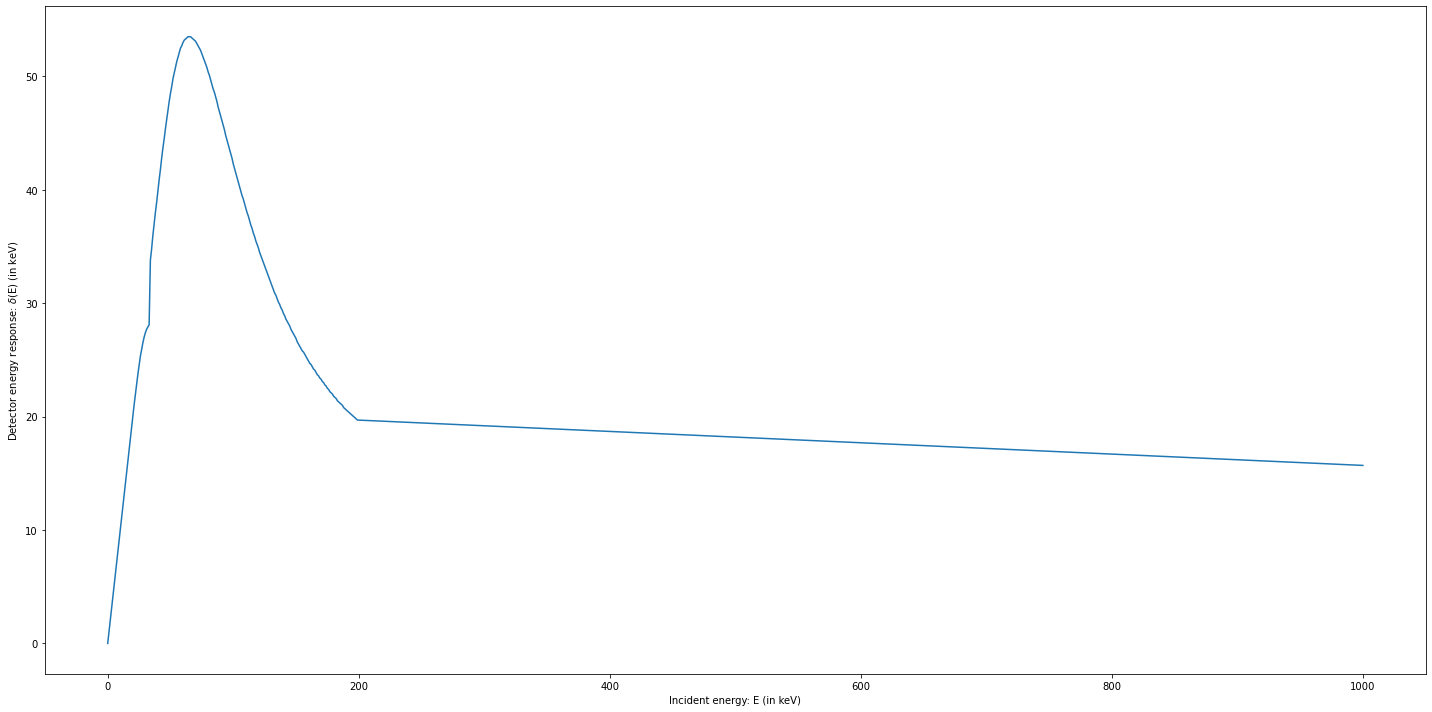

In [21]:
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

plt.tight_layout()

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [22]:
gvxr.displayScene()

gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(779.6787109375)
gvxr.setSceneRotationMatrix([0.8681427240371704, -0.012712069787085056, -0.4961434006690979, 0.0, 0.005222700070589781, 0.9998429417610168, -0.016478976234793663, 0.0, 0.4962790608406067, 0.011715104803442955, 0.8680806159973145, 0.0, 0.0, 0.0, 0.0, 1.0])

gvxr.displayScene()

0 0 500 500


In [23]:
# gvxr.renderLoop()

# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

In [24]:
screenshot = gvxr.takeScreenshot()

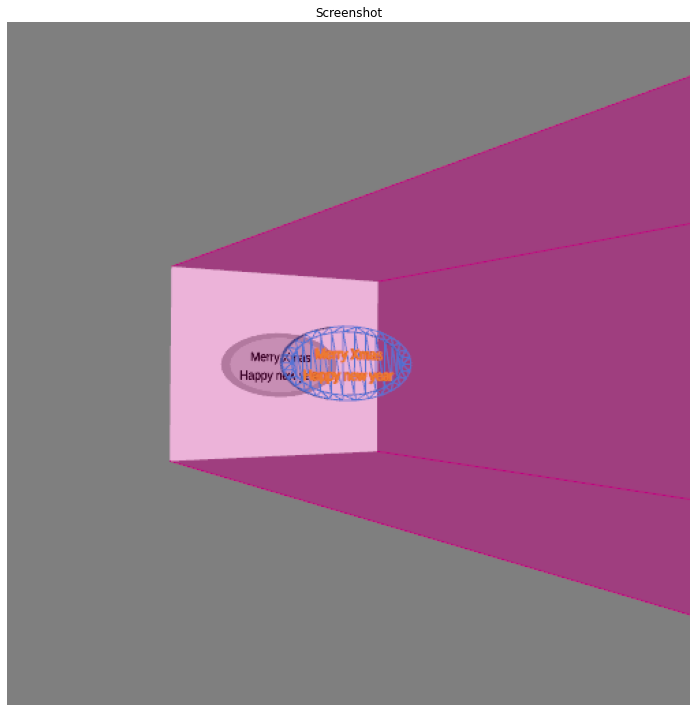

In [25]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

 Update set of projections while rotating the scene to mimick CT acquisition

In [26]:
%%capture

if not os.path.exists("flat.mha"):

    raw_projections = [];

    # Create a GIF file
    writer = None
    fname_gif = "CT_acquisition.gif"

    # if not os.path.exists(fname_gif):
    writer = imageio.get_writer(fname_gif, mode='I')

    # Save the transformation matrix
    transformation_matrix_backup = gvxr.getSceneTransformationMatrix()
    
    for angle_id in range(0, number_of_projections):

        # Compute an X-ray image    
        xray_image = np.array(gvxr.computeXRayImage());

        # Add to the set of projections
        raw_projections.append(xray_image)

        # Update the rendering
        gvxr.displayScene();

        # Take a screenshot
        if writer is not None:
            if not angle_id % 30:
                screenshot = gvxr.takeScreenshot()

                plt.figure(figsize= (10,10))
                plt.title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(screenshot)
                plt.axis('off')

                plt.tight_layout()

                plt.savefig('temp.png')            
                plt.close()


                image = imageio.imread("temp.png")
                writer.append_data(image)

        # Rotate the sample
        gvxr.rotateScene(-angular_step, 0, 1, 0);

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(transformation_matrix_backup)

    # Update the rendering
    gvxr.displayScene();

    # We're done with the writer
    if writer is not None:
        writer.close()
        # os.remove(temp.tif)

    # Convert to numpy arrays
    raw_projections = np.array(raw_projections)

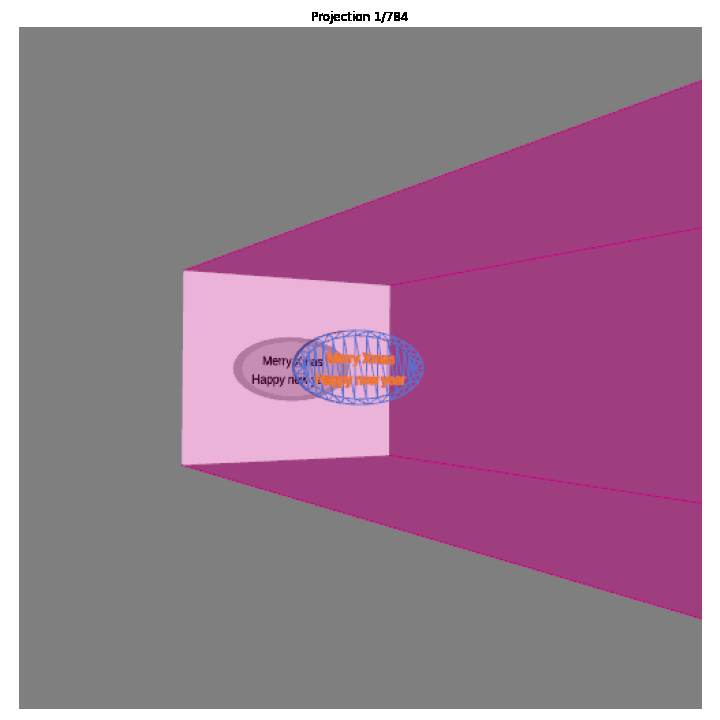

In [27]:
with open('CT_acquisition.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=500))

# Perform flat-field correction

In [28]:
if not os.path.exists("flat.mha"):

    # Create a mock dark field image
    dark_field_image = np.zeros(raw_projections.shape);

    # Create a mock flat field image
    flat_field_image = np.ones(raw_projections.shape);

    # Retrieve the total energy
    total_energy = 0.0;
    energy_bins = gvxr.getEnergyBins("MeV");
    photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

    for energy, count in zip(energy_bins, photon_count_per_bin):
        total_energy += energy * count;
    flat_field_image *= total_energy;

    # Apply the actual flat-field correction on the raw projections
    corrected_projections = (raw_projections - dark_field_image) / (flat_field_image - dark_field_image)
    # corrected_projections = tomopy.normalize(raw_projections, flat_field_image, dark_field_image)

    raw_projections = None # Not needed anymore

## Save the projections using SimpleITK

In [29]:
if not os.path.exists("flat.mha"):

    corrected_projections = np.array(corrected_projections).astype(np.single)

    sitk_image = sitk.GetImageFromArray(corrected_projections)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, "flat.mha", useCompression=True) 
else:
    temp = sitk.ReadImage("flat.mha")
    corrected_projections = sitk.GetArrayFromImage(temp)

## Calculate $-\log(\mathbf{corrected\_projections}) $ to linearize transmission tomography data

In [30]:
if not os.path.exists("sinograms.mha"):
    # Create a temporary image to hold the sinogram
    minus_log_projs = np.copy(corrected_projections);

    # Make sure no value is negative or null (because of the log function)
    # It should not be the case, however, when the Laplacian is used to simulate
    # phase contrast, negative values can be generated.
    threshold = 0.000000001
    minus_log_projs[minus_log_projs < threshold] = threshold;

    # Apply the minus log normalisation
    minus_log_projs = -np.log(minus_log_projs);

    # Rescale the data taking into account the pixel size
    pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
    minus_log_projs /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

    # Make sure the data is in single-precision floating-point numbers
    minus_log_projs = np.array(minus_log_projs).astype(np.single)

else:
    temp = sitk.ReadImage("sinograms.mha")
    minus_log_projs = sitk.GetArrayFromImage(temp)
    
# Reformat the projections into a set of sinograms
sinograms = np.swapaxes(minus_log_projs, 0, 1)
sinograms = np.array(sinograms).astype(np.single)

corrected_projections = None # Not needed anymore

Save the volume using SimpleITK

In [31]:
if not os.path.exists("sinograms.mha"):
    sitk_image = sitk.GetImageFromArray(minus_log_projs)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
    sitk.WriteImage(sitk_image, "sinograms.mha", useCompression=True)

Plot some sinograms

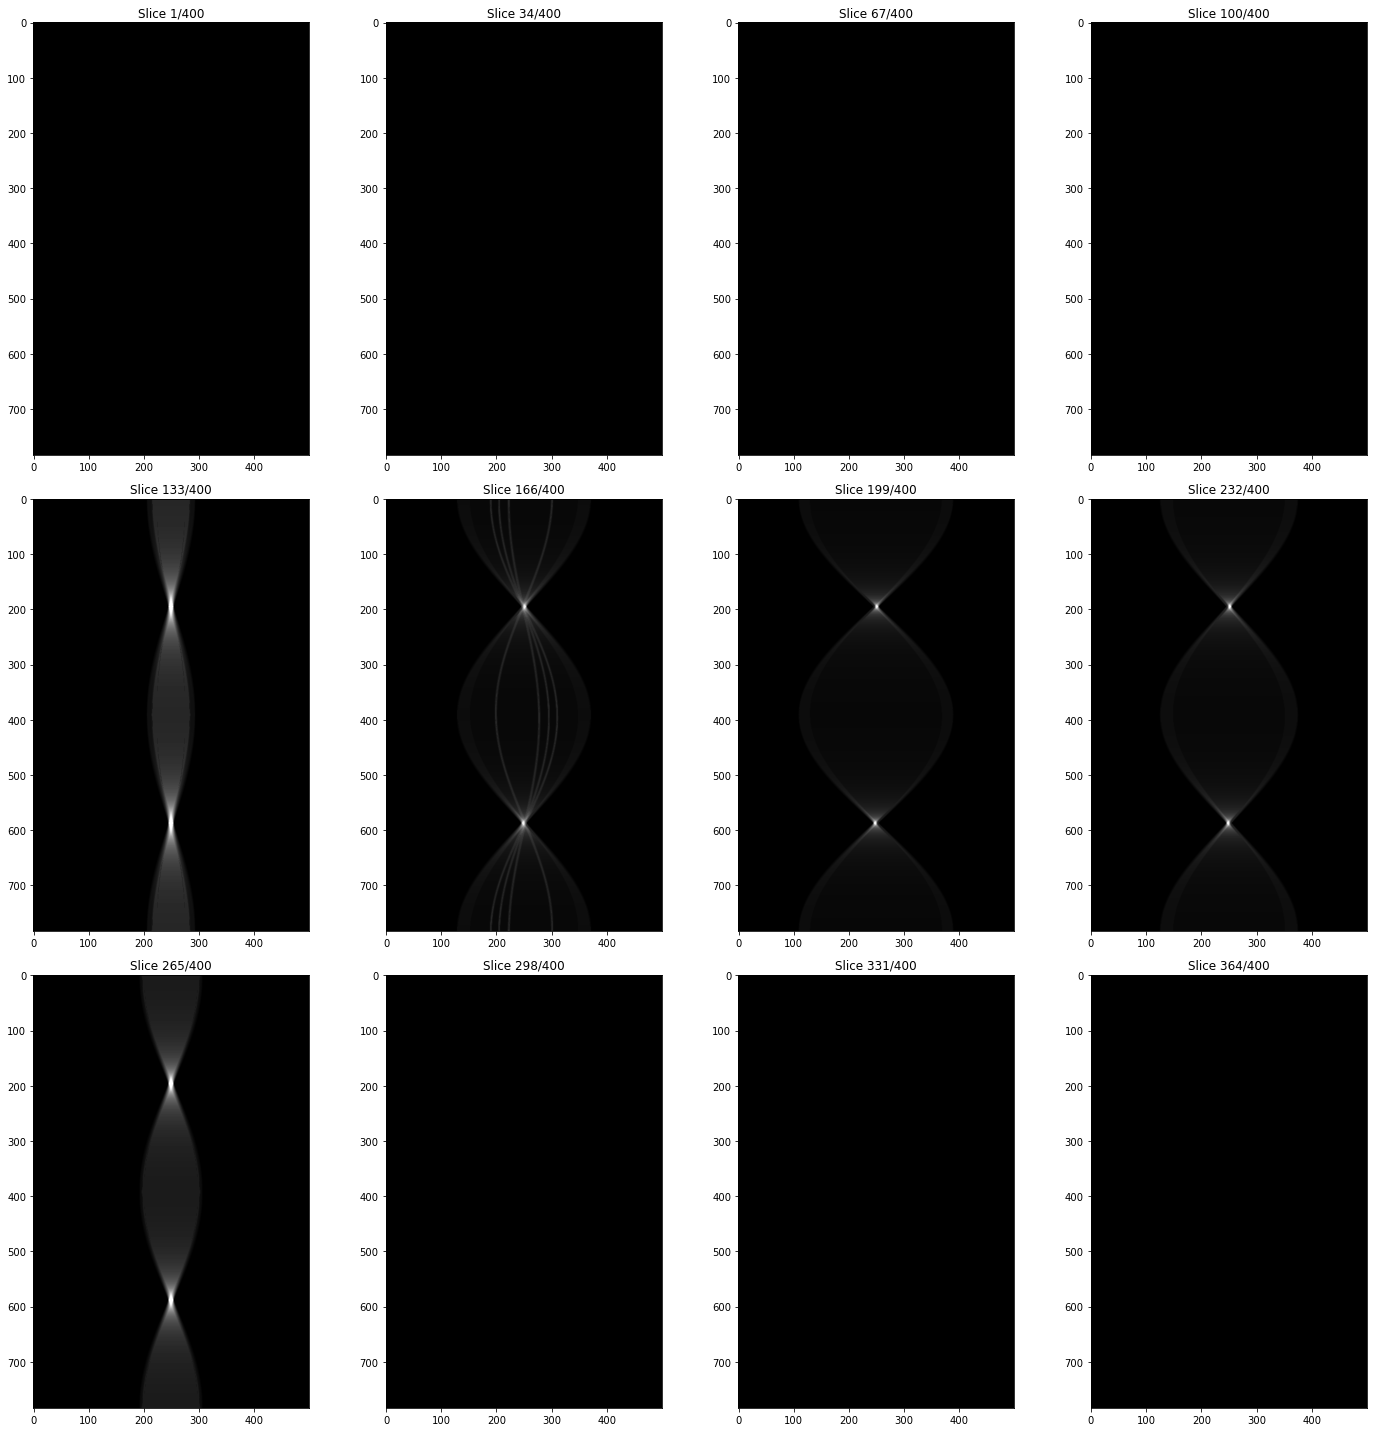

In [32]:
ncols = 4
nrows = 3

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id], cmap='gray')
        
plt.tight_layout()

Find the rotation axis using Tomopy

In [33]:
# rot_center = tomopy.find_center(sinograms, theta, init=290, ind=0, tol=0.5)

Reconstruct the CT slice using Tomopy

In [34]:
if not os.path.exists("CT-volume.mha"):
    theta_rad = np.array(theta_deg) * math.pi / 180
    rot_centre = minus_log_projs.shape[2] / 2
    # rot_centre = tomopy.find_center(minus_log_projs, theta_rad, init=rot_centre, ind=0, tol=0.01)
    print("Projection sizes:", minus_log_projs.shape)
    print("Rotation centre:", rot_centre)
    CT_volume_in_mu = tomopy.recon(minus_log_projs,
                             theta_rad,
                             center=rot_centre,
                             algorithm='gridrec',
                             sinogram_order=False)

sinogram = None # Not needed anymore

Projection sizes: (784, 400, 500)
Rotation centre: 250.0


Reconstruct the CT slice using Scikit-Image

In [35]:
# if not os.path.exists("CT-volume.mha"):
#     CT_volume_in_mu = []

#     for sinogram in sinograms:
#         CT_volume_in_mu.append(iradon(sinogram.T, theta=theta_deg, circle=True))

# sinogram = None # Not needed anymore

Save the volume using SimpleITK

In [36]:
if not os.path.exists("CT-volume.mha"):
    CT_volume_in_mu = np.array(CT_volume_in_mu).astype(np.single)    
    sitk_image = sitk.GetImageFromArray(CT_volume_in_mu)
    sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])
    sitk.WriteImage(sitk_image, "CT-volume.mha", useCompression=True)
else:
    sitk_image = sitk.ReadImage("CT-volume.mha")
    CT_volume_in_mu = sitk.GetArrayFromImage(sitk_image)

Display the CT slices

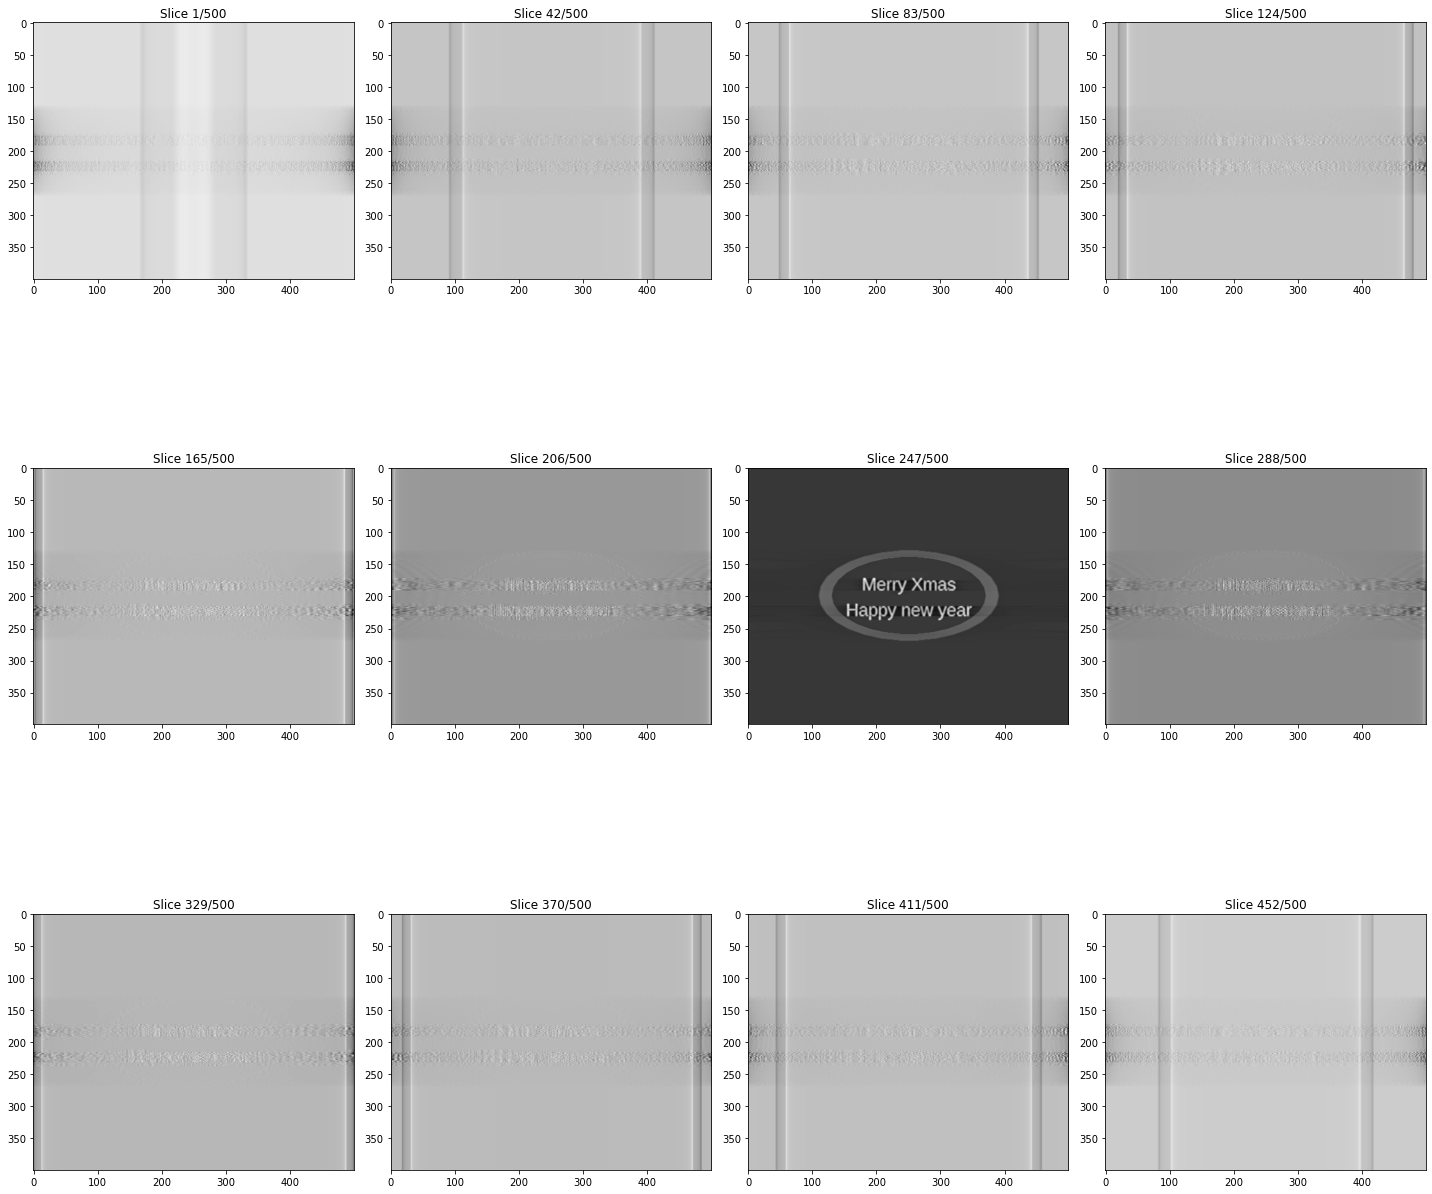

In [37]:
ncols = 4
nrows = 3

CT_volume = np.swapaxes(CT_volume_in_mu, 0, 1)

step = int(CT_volume.shape[0] / (ncols * nrows))
slices = range(0, int(CT_volume.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(CT_volume.shape[0]))
        ax.imshow(np.flip(CT_volume[slice_id], 0), cmap='gray')
        
plt.tight_layout()

## Volume rendering of the CT data

In [38]:
test = CT_volume_in_mu < 0
CT_volume_in_mu[test] = 0

In [39]:
print(CT_volume_in_mu.min(), CT_volume_in_mu.max())

normalised_CT_volume = ((CT_volume_in_mu - CT_volume_in_mu.min()) / (CT_volume_in_mu.max() - CT_volume_in_mu.min())).astype(np.single)
normalised_CT_volume = zoom(normalised_CT_volume, (0.5, 0.5, 0.5))

0.0 3.1451337


In [40]:
plot = k3d.plot()

# loading data to the `density` array
cmap = k3d.colormaps.matplotlib_color_maps.jet

size = np.array(sitk_image.GetSize()) * np.array(sitk_image.GetSpacing())

volume = k3d.volume(
    normalised_CT_volume,
    alpha_coef=5,
    shadow='dynamic',
    samples=300,
    shadow_res=128,
    shadow_delay=50,
    color_range=[0., 0.125],
    color_map=(np.array(cmap).reshape(-1,4)).astype(np.float32)
)

volume.transform.bounds = [-size[0] / 2, size[0] / 2,
                           -size[1] / 2, size[1] / 2,
                           -size[2] / 2, size[2] / 2]

plot = k3d.plot(camera_auto_fit=True, height=400)

plot += volume
plot.display()
plot.camera = [67.0504566038073, -100.57568490571093, 6.705045660380838, 0, 0, 0, 0, 0, 1]

Output()

In [41]:
fname = 'volume_rendering.png'
if not os.path.isfile(fname):

    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    plot.fetch_screenshot()

    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

## All done

Destroy the window

In [42]:
gvxr.destroyAllWindows()

gvxrStatus:	Destroy all the windows
gvxrStatus:	Destroy window 0(0x55e6284bc4f0)
